## 1. Dataset Loading

In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [2]:
all_train_images_path=glob.glob('Dataset/seg_train/**/*.jpg')#train images path
all_test_images_path=glob.glob('Dataset/seg_test/**/*.jpg')# test images path
random.seed(21)
random.shuffle(all_train_images_path)
random.shuffle(all_test_images_path)

In [3]:
# Different classes.
classes={'buildings':0,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}
classes_names=list(classes.keys())
classes_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [4]:
#function for loading dataset.
def data_reading(Images_path,classes,img_size=(224,224)):
    images=[]
    labels=[]
    for i in range(len(Images_path)):
        img=cv2.imread(Images_path[i])#reading the images
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#converting the bgr image read by cv2 to rgb
        img=cv2.resize(img,img_size,interpolation=cv2.INTER_CUBIC)# resizing the image to 224*224*3
        images.append(img)
        label=classes[Images_path[i].split('\\')[1]]#finding the class index
        labels.append(label)
    images=np.array(images)
    labels=np.array(labels)
    return images,labels

In [13]:
train_images,train_labels=data_reading(all_train_images_path,classes,img_size=(224,224))#Dataset loading and resizing
test_images,test_labels=data_reading(all_test_images_path,classes,img_size=(224,224))#Dataset loading and resizing

print('Train Images Shape:',train_images.shape)# Train images of 14034
print('Test Images Shape:',test_images.shape)# Test images of 3000

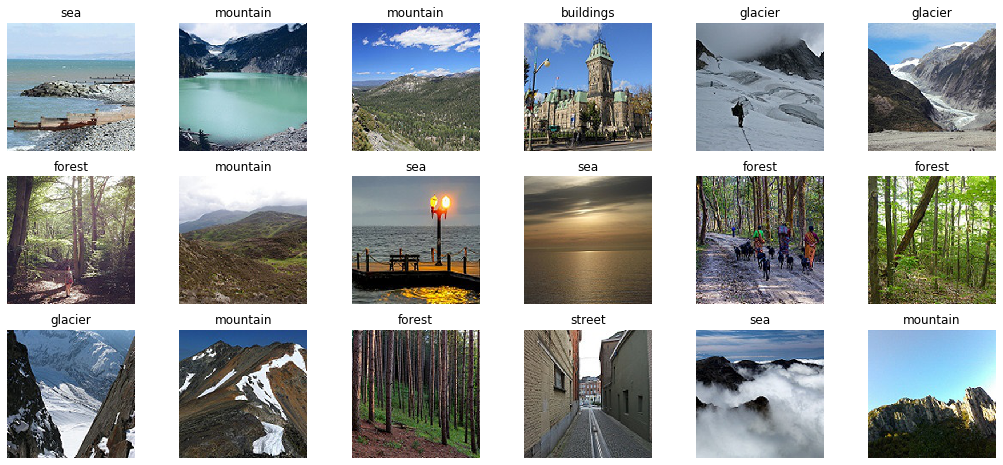

In [6]:
# Showing first 18 images. and their labels using pyplot.
plt.figure(figsize=(18,8))
for i in range (0,18):
    plt.subplot(3,6,i+1)
    img1=train_images[i]
    plt.imshow(img1)
    plt.title(classes_names[train_labels[i]])
    plt.axis('off')
plt.show()

## 2. Dataset Augmentation:

In [5]:
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise

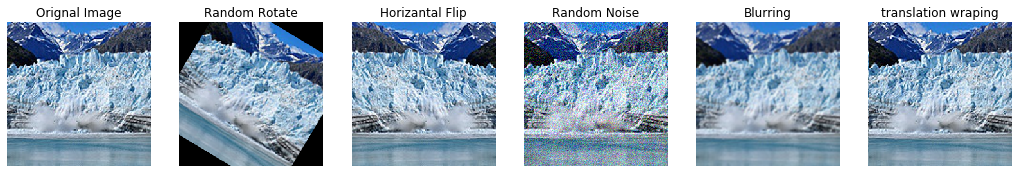

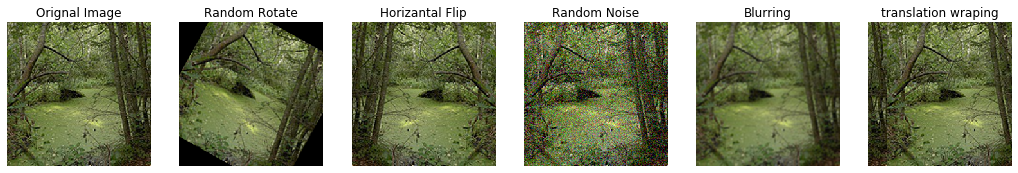

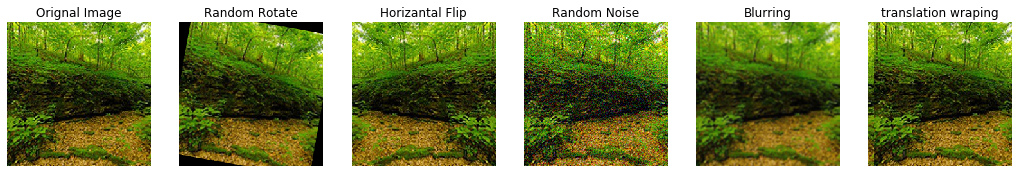

In [577]:
# Showing first 18 images. and their labels using pyplot.
for i in range(3):
    plt.figure(figsize=(18,8))
    ###################
    plt.subplot(1,6,1)#-negative for clockwise and positive for anticlockwise
    plt.imshow(train_images[i])
    plt.title('Orignal Image')
    plt.axis('off')
    ###################
    plt.subplot(1,6,2)# image fliping horizantal
    plt.imshow(rotate(train_images[i], random.randint(-60,60)))
    plt.title('Random Rotate')
    plt.axis('off')
    ###################
    plt.subplot(1,6,3)# random image noise
    plt.imshow(np.fliplr(train_images[i]))
    plt.title('Horizantal Flip')
    plt.axis('off')
    ###################
    plt.subplot(1,6,4)
    plt.imshow(random_noise(train_images[i]))
    plt.title('Random Noise')
    plt.axis('off')
    ###################
    plt.subplot(1,6,5)# image blurring
    plt.imshow(cv2.GaussianBlur(train_images[i], (5,5),0))
    plt.title('Blurring')
    plt.axis('off')
    ###################
    plt.subplot(1,6,6)# image translation wraping
    plt.imshow(warp(train_images[i], AffineTransform(translation=(random.randint(-30,30),0)), mode="wrap"))
    plt.title('translation wraping')
    plt.axis('off')
    ###################
    plt.show()

In [6]:
#function for loading dataset.
def data_reading_with_augmentation(Images_path,classes,img_size=(224,224)):
    images=[]
    labels=[]
    for i in range(len(Images_path)):
        img=cv2.imread(Images_path[i])#reading the images
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#converting the bgr image read by cv2 to rgb
        img=cv2.resize(img,img_size,interpolation=cv2.INTER_CUBIC)# resizing the image to 224*224*3
        images.append(img)
        label=classes[Images_path[i].split('\\')[1]]#finding the class index
        labels.append(label)
        
        random_number=random.randint(0,4)
        if random_number==0:
            #-negative for clockwise and positive for anticlockwise
            images.append(rotate(img, random.randint(-60,60)))
            labels.append(label)
        if random_number==1:
            # image fliping horizantal
            images.append(np.fliplr(img))
            labels.append(label)
        if random_number==2:
            # random image noise
            images.append(random_noise(img))
            labels.append(label)
        if random_number==3:
            # image blurring
            images.append(cv2.GaussianBlur(img, (5,5),0))
            labels.append(label)
        if random_number==4:
            # image translation wraping
            images.append(warp(img, AffineTransform(translation=(random.randint(-30,30),0)), mode="wrap"))  
            labels.append(label)
        
    images=np.array(images)
    labels=np.array(labels)
    return images,labels

### Note: Run Only if you have good amount of Ram

In [ ]:
train_images_aug,train_labels_aug=data_reading_with_augmentation(all_train_images_path,classes,img_size=(224,224))
print('Train Images Shape:',train_images_aug.shape)# Train images of 14034

In [ ]:
# As it taking too much memory thats why we are deleting it and loading the data at real time.
del train_images_aug
del train_labels_aug
del train_images
del train_labels
del test_images
del test_labels

## 3. Convolutional Neural Network:

#### Model1:

In [22]:
from keras import layers,Input
from keras.models import Model
from keras.layers.core import Dense,Dropout
from keras.optimizers import SGD,Adam
from keras.utils import np_utils

class CNNNet1:
    def build(width, height, depth, classes):
        # initialize the model
        input1 = Input(shape=(height, width,depth))
        
        x1=layers.ZeroPadding2D(padding=(2, 2))(input1)## Zero padding on the sides
        x1=layers.Conv2D(16, (3, 3),padding='valid',activation='relu',use_bias=False)(x1) ##CNN LAYER1
        x1=layers.ZeroPadding2D(padding=(2, 2))(x1)#Zero padding so information not loss at the edges.
        x1=layers.Conv2D(16, (3, 3),padding='valid',activation='relu',use_bias=False)(x1)##CNN LAYER2
        x1=layers.ZeroPadding2D(padding=(4, 4))(x1)
        x1=layers.Conv2D(16, (5, 5),dilation_rate=(2,2),padding='valid',activation='relu',use_bias=False)(x1)##CNN LAYER3
        x1=layers.AveragePooling2D(pool_size=(2, 2))(x1)# average pooling layers. Reducing the size of layer, by replacing the average of 4 entries at one place.
        
        x1_1=layers.Conv2D(16, (3, 3),dilation_rate=(2,2),padding='valid',activation='relu',use_bias=False)(x1)##CNN LAYER4
        x1_1=layers.BatchNormalization()(x1_1)# batch nomalization layer
        x1_1=layers.MaxPooling2D(pool_size=(2, 2))(x1_1)# Max pooling layer.
        
        x1_2=layers.ZeroPadding2D(padding=(2, 2))(x1)
        x1_2=layers.Conv2D(16, (5, 5),dilation_rate=(2,2),padding='valid',activation='relu',use_bias=False)(x1_2)##CNN LAYER5
        x1_2=layers.BatchNormalization()(x1_2)# batch nomalization layer
        x1_2=layers.MaxPooling2D(pool_size=(2, 2))(x1_2)# Max pooling layer.
        
        x1_3=layers.ZeroPadding2D(padding=(4, 4))(x1)
        x1_3=layers.Conv2D(16, (7, 7),dilation_rate=(2,2),padding='valid',activation='relu',use_bias=False)(x1_3)##CNN LAYER6
        x1_3=layers.BatchNormalization()(x1_3)# batch nomalization layer
        x1_3=layers.MaxPooling2D(pool_size=(2, 2))(x1_3)# Max pooling layer.
        
        concatenated0 = layers.concatenate([x1_1, x1_2,x1_3], axis=-1)
        concatenated0=layers.Conv2D(32, (5, 5),dilation_rate=(2,2),padding='valid',activation='relu',use_bias=False)(concatenated0)##CNN LAYER7
        concatenated0=layers.Dropout(0.1)(concatenated0) #dropput at the probability of 10%.
        concatenated0=layers.AveragePooling2D(pool_size=(2, 2))(concatenated0)
#         # second set of CONV => RELU => POOL layers
        concatenated0=layers.Conv2D(32, (3, 3),activation='relu')(concatenated0)##CNN LAYER8
        concatenated0=layers.BatchNormalization()(concatenated0)# batch nomalization layer
        concatenated0=layers.MaxPooling2D(pool_size=(2, 4))(concatenated0)# Max pooling layer.
        
        # first (and only) set of FC => RELU layers
        x3=layers.Flatten()(concatenated0)
        x3=layers.Dense(256)(x3)##FC LAYER1
        x3=layers.Activation("relu")(x3)
        
        x3=layers.Dense(16)(x3)##FC LAYER2
        x3=layers.Activation("relu")(x3)
        x3=layers.BatchNormalization()(x3)# batch nomalization layer
        x3 =layers.Dropout(0.1)(x3)#dropput at the probability of 10%.
        x3 =layers.Dense(16, activation="relu")(x3)##FC LAYER3
        predictions = Dense(classes, activation='softmax')(x3)## OUTPUT LAYER
        model = Model(input1, predictions)
        model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.1),metrics=["acc"])
        return model

model1 = CNNNet1.build(224,224,3,len(classes_names))
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 228, 228, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 226, 226, 16) 432         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 16) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.1),metrics=["acc"])

In [67]:
acc=[]
val_acc=[]
loss=[]
val_loss=[]

for g in range(10):
    random.shuffle(all_train_images_path)
    for i in range(0,len(all_train_images_path),4000):#len(all_train_images_path)
        train_images_aug=[]
        train_images_aug,train_labels_aug=data_reading_with_augmentation(all_train_images_path[i:i+4000],classes,img_size=(224,224))
        train_images_aug=train_images_aug/255.
        train_labels_aug=np_utils.to_categorical(train_labels_aug)

        batch_size=64
        hist=model1.fit(train_images_aug,train_labels_aug,batch_size=batch_size,epochs=8,validation_split=0.1)

        acc=acc+hist.history['acc']
        val_acc=val_acc+hist.history['val_acc']
        loss=loss+hist.history['loss']
        val_loss=val_loss+hist.history['val_loss']    

Train on 7200 samples, validate on 800 samples
Epoch 1/8
7200/7200 [==============================] - 79s 11ms/step - loss: 0.5676 - acc: 0.7665 - val_loss: 0.7067 - val_acc: 0.7337
Epoch 2/8
7200/7200 [==============================] - 79s 11ms/step - loss: 0.5299 - acc: 0.7764 - val_loss: 0.9248 - val_acc: 0.7175
Epoch 3/8
7200/7200 [==============================] - 79s 11ms/step - loss: 0.5275 - acc: 0.7783 - val_loss: 0.8089 - val_acc: 0.7200
Epoch 4/8
7200/7200 [==============================] - 79s 11ms/step - loss: 0.5131 - acc: 0.7824 - val_loss: 0.8777 - val_acc: 0.7375
Epoch 5/8
7200/7200 [==============================] - 79s 11ms/step - loss: 0.5176 - acc: 0.7757 - val_loss: 1.0852 - val_acc: 0.7237
Epoch 6/8
7200/7200 [==============================] - 79s 11ms/step - loss: 0.5149 - acc: 0.7828 - val_loss: 1.1627 - val_acc: 0.7125
Epoch 7/8
7200/7200 [==============================] - 79s 11ms/step - loss: 0.5014 - acc: 0.7837 - val_loss: 0.9814 - val_acc: 0.7212
Epoch 8/

In [80]:
model1.save('model/model1.h5')

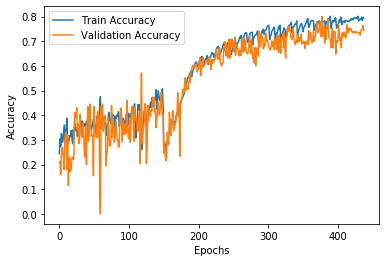

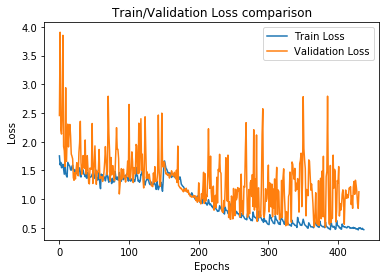

In [77]:
import matplotlib.pyplot as plt
plt.plot(acc,label='Train Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Train_Validation_Accuracy_comparison1.png')
plt.show()

plt.plot(loss,label='Train Loss')
plt.plot(val_loss,label='Validation Loss')
plt.title('Train/Validation Loss comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Train_Validation_Loss_comparison1.png')
plt.show()

In [81]:
from sklearn.metrics import accuracy_score
predicted_labels = model1.predict(test_images/255) #predicting on test images
predicted_labels=np.argmax(predicted_labels,axis=1) # Converting Returned categorical to numbers. 
accuracy = accuracy_score(test_labels, predicted_labels) * 100
accuracy

80.83333333333333

#### Confusion Metric

In [84]:
from sklearn.metrics import confusion_matrix
import pandas as pd
print ("Confusion matrix")
#confusion matrix between predicted and actual truths
pd.DataFrame(confusion_matrix(test_labels,predicted_labels),columns=classes_names,index=classes_names)

Confusion matrix


,buildings,forest,glacier,mountain,sea,street
buildings,339,3,2,6,27,60
forest,5,452,2,3,0,12
glacier,3,4,393,102,48,3
mountain,3,3,70,413,33,3
sea,12,2,58,16,415,7
street,56,11,5,6,10,413


#### Model2:

In [7]:
from keras import layers,Input
from keras.models import Model
from keras.layers.core import Dense,Dropout
from keras.optimizers import SGD,Adam
from keras.utils import np_utils

class CNNNet2:
    def build(width, height, depth, classes):
        # initialize the model
        input1 = Input(shape=(height, width,depth))
        
        x1=layers.Conv2D(16, (3, 3),padding='valid',activation='relu',use_bias=False)(input1) #cnn layer1
        x1=layers.Conv2D(16, (3, 3),padding='valid',activation='relu',use_bias=False)(x1) #cnn layer2
        x1=layers.Conv2D(32, (5, 5),padding='valid',activation='relu',use_bias=False)(x1) #cnn layer3
        x1=layers.MaxPooling2D(pool_size=(2, 2))(x1) # max pooling layer 1
        
        x1=layers.Conv2D(32, (5, 5),dilation_rate=(2,2),padding='valid',activation='relu',use_bias=False)(x1)#cnn layer4
        x1=layers.BatchNormalization()(x1) #batch normalization layer 1
       
        x1=layers.Conv2D(64, (5, 5),dilation_rate=(2,2),padding='valid',activation='relu',use_bias=False)(x1)#cnn layer5
        x1=layers.Dropout(0.1)(x1)
        x1=layers.MaxPooling2D(pool_size=(2, 2))(x1) # max pooling layer 2
        
#         # second set of CONV => RELU => POOL layers
        x1=layers.Conv2D(64, (7, 7),activation='relu')(x1)#cnn layer6
        x1=layers.BatchNormalization()(x1)#batch normalization layer 2
        x1=layers.MaxPooling2D(pool_size=(2, 2))(x1) # max pooling layer 3
        
        x1=layers.Conv2D(64, (7, 7),activation='relu')(x1)#cnn layer7
        x1=layers.BatchNormalization()(x1)#batch normalization layer 3
        x1=layers.Dropout(0.1)(x1)
        
        
        x1=layers.Conv2D(128, (7, 7),activation='relu')(x1)#cnn layer8
        x1=layers.BatchNormalization()(x1)#batch normalization layer 4
        x1=layers.MaxPooling2D(pool_size=(2, 2))(x1) # max pooling layer 4
        x1=layers.Dropout(0.1)(x1)
        
        x1=layers.Conv2D(128, (3, 3),activation='relu')(x1)#cnn layer9
        x1=layers.BatchNormalization()(x1)#batch normalization layer 1
        x1=layers.Dropout(0.1)(x1)
        
        x1=layers.Flatten()(x1)
        x1=layers.Dense(256)(x1)
        x1=layers.Dropout(0.3)(x1)
        x1=layers.Activation("relu")(x1)
        x1=layers.BatchNormalization()(x1)
        
        # output layer
        predictions = Dense(classes, activation='softmax')(x1)
        # At model instantiation, we specify the two inputs and the output:
        model = Model(input1, predictions)
        model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.01),metrics=["acc"])
        # return the constructed network architecture
        return model

model2 = CNNNet2.build(224,224,3,len(classes_names))
model2.summary()

Using TensorFlow backend.
C:\Users\afaq.ahmad\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\afaq.ahmad\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\afaq.ahmad\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\afaq.ahmad\.conda\envs\tf_gpu

C:\Users\afaq.ahmad\.conda\envs\tf_gpu\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\afaq.ahmad\.conda\envs\tf_gpu\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\afaq.ahmad\.conda\envs\tf_gpu\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\afaq.ahmad\.conda\envs\tf_gpu\lib\

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      432       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 16)      2304      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 216, 216, 32)      12800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 108, 108, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 32)      25600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128 

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001),metrics=["acc"])

In [ ]:
acc=[]
val_acc=[]
loss=[]
val_loss=[]
        
for g in range(10):
    random.shuffle(all_train_images_path)
    for i in range(0,len(all_train_images_path),4000):#len(all_train_images_path)
        train_images_aug=[]
        train_images_aug,train_labels_aug=data_reading_with_augmentation(all_train_images_path[i:i+4000],classes,img_size=(224,224))
        train_images_aug=train_images_aug/255. #Normalization of features
        train_labels_aug=np_utils.to_categorical(train_labels_aug) #converting number based classes to categorical classes.

        batch_size=64
        hist=model2.fit(train_images_aug,train_labels_aug,batch_size=batch_size,epochs=8,validation_split=0.1)

        acc=acc+hist.history['acc']
        val_acc=val_acc+hist.history['val_acc']
        loss=loss+hist.history['loss']
        val_loss=val_loss+hist.history['val_loss']    

In [475]:
model2.save('model/model2.h5')

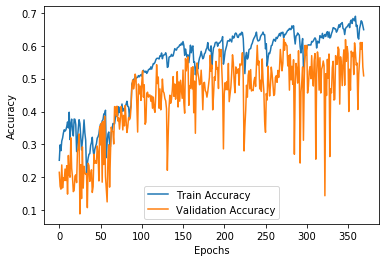

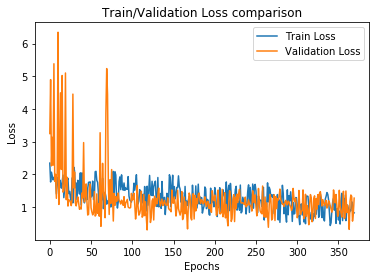

In [572]:
import matplotlib.pyplot as plt

plt.plot(acc,label='Train Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Train_Validation_Accuracy_comparison2.png')
plt.show()


plt.plot(loss,label='Train Loss')
plt.plot(val_loss,label='Validation Loss')
plt.title('Train/Validation Loss comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Train_Validation_Loss_comparison2.png')
plt.show()

In [575]:
from sklearn.metrics import accuracy_score
predicted_labels = model2.predict(test_images/255)#predicting on test images
predicted_labels=np.argmax(predicted_labels,axis=1)# Converting Returned categorical to numbers.
accuracy = accuracy_score(test_labels, predicted_labels) * 100
accuracy

78.2

#### Confusion Metric

In [578]:
from sklearn.metrics import confusion_matrix
import pandas as pd
print ("Confusion matrix")
pd.DataFrame(confusion_matrix(test_labels,predicted_labels),columns=classes_names,index=classes_names)

Confusion matrix


,buildings,forest,glacier,mountain,sea,street
buildings,325,15,10,16,18,53
forest,0,461,2,6,2,3
glacier,7,14,367,98,65,2
mountain,1,22,55,409,37,1
sea,5,3,37,81,379,5
street,40,33,6,9,8,405


### Pretrained Model (Resnet-50)

In [9]:
from keras.applications.resnet import ResNet50
from keras import regularizers
from keras import layers,Input
from keras.models import Model
from keras.layers.core import Dense,Dropout
from keras.optimizers import SGD,Adam
from keras.utils import np_utils

In [ ]:
# from keras.models import load_model
# model_resnet = load_model('model/model_resnet.h5')# loading model_resnet

In [ ]:
def Resnet50_model():
    initial_model: Model =ResNet50(weights='imagenet',  input_shape=(224,224,3), classes=1000)

    initial_model.trainable = True
    for i, layer in enumerate(initial_model.layers):
        layer.trainable = True

    # We include MobileNetV2 layers directly in the final model.
    initial_model_output = initial_model.output
    
    x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(initial_model_output)
    predictions = layers.Dense(len(classes_names), activation='softmax')(x)

    model = Model(initial_model.input, predictions)
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001),metrics=["acc"])
    return model

In [12]:
# from keras import backend as K
# # To get learning rate
# print(K.get_value(model_resnet.optimizer.lr))
# # # To set learning rate
# K.set_value(model_resnet.optimizer.lr, 0.0001)

0.001


In [8]:
model_resnet=Resnet50_model()
model_resnet.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
acc=[]
val_acc=[]
loss=[]
val_loss=[]
        
for g in range(10):
    random.shuffle(all_train_images_path)
    for i in range(0,len(all_train_images_path),1000):#len(all_train_images_path)
        train_images_aug=[]
        train_images_aug,train_labels_aug=data_reading_with_augmentation(all_train_images_path[i:i+1000],classes,img_size=(224,224))
        train_images_aug=train_images_aug/255. #Normalization of features
        train_labels_aug=np_utils.to_categorical(train_labels_aug) #converting number based classes to categorical classes.

        batch_size=16
        hist=model_resnet.fit(train_images_aug,train_labels_aug,batch_size=batch_size,epochs=1,validation_split=0.1)

        acc=acc+hist.history['acc']
        val_acc=val_acc+hist.history['val_acc']
        loss=loss+hist.history['loss']
        val_loss=val_loss+hist.history['val_loss']
    from sklearn.metrics import accuracy_score
    predicted_labels = model_resnet.predict(test_images/255)
    predicted_labels=np.argmax(predicted_labels,axis=1)
    accuracy = accuracy_score(test_labels, predicted_labels) * 100
    print ('accuracy:',accuracy)
    model_resnet.save('model/model_resnet.h5'+str(g))#saving the weights

In [16]:
model_resnet.save('model/model_resnet.h5')#saving the weights

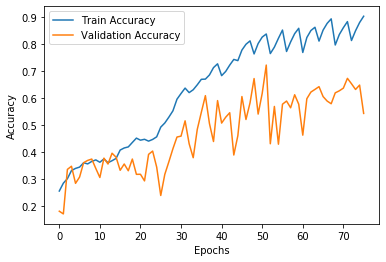

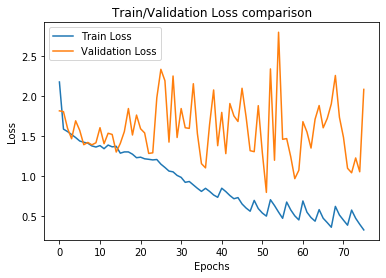

In [26]:
import matplotlib.pyplot as plt
plt.plot(acc,label='Train Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Train_Validation_Accuracy_comparison_resnet.png')
plt.show()


plt.plot(loss,label='Train Loss')
plt.plot(val_loss,label='Validation Loss')
plt.title('Train/Validation Loss comparison')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Train_Validation_Loss_comparison_resnet.png')
plt.show()

In [15]:
from sklearn.metrics import accuracy_score
predicted_labels = model_resnet.predict(test_images/255)
predicted_labels=np.argmax(predicted_labels,axis=1)
accuracy = accuracy_score(test_labels, predicted_labels) * 100
accuracy

87.4

#### Confusion Metric

In [17]:
from sklearn.metrics import confusion_matrix
import pandas as pd
print ("Confusion matrix")
pd.DataFrame(confusion_matrix(test_labels,predicted_labels),columns=classes_names,index=classes_names)

Confusion matrix


,buildings,forest,glacier,mountain,sea,street
buildings,366,4,1,7,8,51
forest,1,462,1,5,3,2
glacier,6,1,418,90,33,5
mountain,4,3,40,455,23,0
sea,6,1,11,22,463,7
street,27,8,0,2,6,458


### Testing on Own Images:

So we have trained 3 model, the best model that have maximum accuracy is Resnet50 pretrained on imagenet. So checking the results on our own images uisng Resnet50.

In [18]:
from keras.models import load_model
model1 = load_model('model/model_resnet.h5')# loading model1

In [19]:
import glob
images_path=glob.glob('Testing_images/*')# loading own testing images.

In [20]:
img_size=224,224
All_images=[]
for i in range(len(images_path)):
    img=cv2.imread(images_path[i])#reading the images
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#converting the bgr image read by cv2 to rgb
    img=cv2.resize(img,img_size,interpolation=cv2.INTER_CUBIC)# resizing the image to 224*224*3
    All_images.append(img)
All_images=np.array(All_images)
All_images.shape

(6, 224, 224, 3)

In [21]:
predicted_labels=np.argmax(model1.predict(All_images/255),axis=1)# predicting using the model and converting it to general class numbers.
predicted_labels

array([0, 1, 2, 3, 4, 5], dtype=int64)

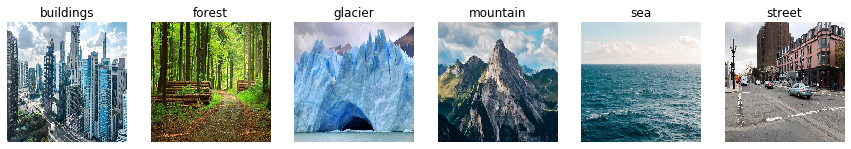

In [22]:
# Showing first tested images. and their predicted labels using pyplot.
plt.figure(figsize=(15,10))
for i in range (0,len(images_path)):
    plt.subplot(int(len(images_path)/6),len(images_path),i+1)
    img1=All_images[i]
    plt.imshow(img1)
    plt.title(classes_names[predicted_labels[i]])
    plt.axis('off')
plt.show()